# Classification using Decision Trees

Decision trees are among the most popular classical machine learning algorithms, which can used for both classification (so-called classification trees) and regression (so-called regression trees). In this notebook, we will use decision trees for classification. 

Our implementation will be based on the open source machine learning library [scikit-learn](https://scikit-learn.org/stable/index.html). For simplicity and interpretability, we will use some synthetic 2D data in this notebook. In [regression_decision_tree.ipynb](regression_decision_tree.ipynb), we will use some scientific data to learn regression with decision trees.

In [1]:
# sklearn
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import sklearn.datasets

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Helper Functions

These are a few helper functions for generating data, plotting etc. You do not necessarily need to understand all the contents of these functions.

In [2]:
def generate_toy_data():
    centers= np.random.RandomState(0).uniform(-10, 10, size=(4, 2))
    X, y = make_blobs(n_samples=300, n_features=2, centers=centers,
                               cluster_std=1.5, random_state=0)
    return X, y

def plot_points(X, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    scat = ax.scatter(X[:, 0], X[:, 1], c=y, s=20, alpha=0.7, edgecolors='k')
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Feature 1')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                                    title='Classes'))
    
# function to visualise classification
def visualize_classifier(X, y, model, ax=None, cmap='viridis'):
    ax = ax or plt.gca()
    
    # plot the training points
    scat = ax.scatter(X[:, 0], X[:, 1], c=y, s=20, alpha=0.7, edgecolors='k',
                      clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create a structured grid of the entire space
    x0, x1 = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    
    # compute model predictions on the grid
    y_pred = model.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)

    # create a contour plot of the grid
    n_classes = len(np.unique(y))
    ax.contourf(x0, x1, y_pred, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

---

# Data generation & Training/Test Split

We start by generating a dataset using the `make_blobs` method from `sklearn`. This method can generate multi-dimensional random data points (blobs) in a Gaussian distribution around a specific number of centres.

We split the data randomly by into a training and test set in the ratio 75/25.

In the following cell, we generate a dataset of 300 samples in 2D (2 features) with 4 centres (four classes). 

In [3]:
# generate Gaussian blobs
X, y = generate_toy_data()

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
X_train.shape, X_test.shape, 

((225, 2), (75, 2))

The target classes have four values only, these correspond to the colours in the plots below.

In [5]:
list(set(y_test))

[0, 1, 2, 3]

**NOTE: Had to change the line below!!!**

```
plot_points(X_test, y_test, ax=ax2)
```

Text(0.5, 1.0, 'Test Set')

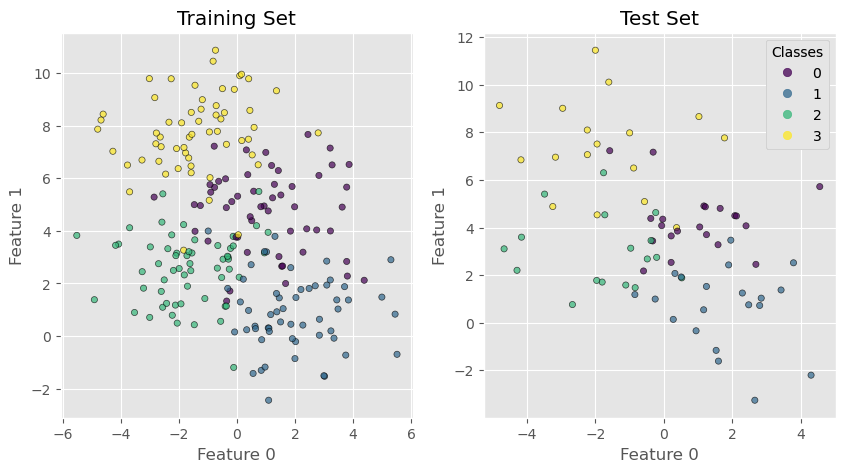

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_points(X_train, y_train, ax=ax1)
plot_points(X_test, y_test, ax=ax2)
ax1.set_title('Training Set')
ax2.set_title('Test Set')

---

# Decision Tree

## 1. Create a decision tree classifier

Now we create a `DecisionTreeClassifier` object from `sklearn` to classify the blobs. There are many hyperparameters that can be set for the classifier. We will explain some important ones below. For a full list see [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

* **`max_depth`**

The maximum depth of the tree. If left as `None`, nodes are expanded until all leaves are pure or until all leaves contain fewer than `min_samples_split` samples. Here we use `None`, the default value.

* **`min_samples_split`**

The minimum number of samples required to split an internal node. Here we use `min_samples_split=2`, the default value, so our tree will be a binary tree.
    
* **`max_features`**

The maximum number of features considered for splitting. If left as `None`, the classifier will use `n_features` of the input data. Here we use `None`, the default value, so it will be 2 as there are only 2 features in the input dataset.

In [7]:
# create decision tree
decision_tree = DecisionTreeClassifier(max_depth=None, min_samples_split=2, max_features=None)

## 2. Fit the model to data

In this instance, we do not need to do much feature engineering because our data are relative simple with only two features and four classes. The `DecisionTreeClassifier` class has a `fit()` method, which takes the feature `X` and label `y` as inputs and fits the model to the data:

In [8]:
# fit decision tree
tree = decision_tree.fit(X, y)

The following helper function can be used to visualise the result of the classification. It plots the training data points over a contour plot of model predictions over the entire space.

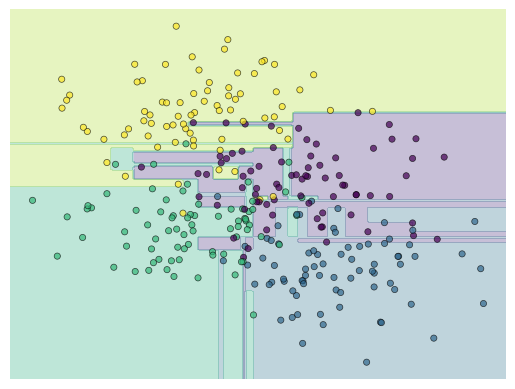

In [9]:
# visualise classification
plt.figure(dpi=100)
visualize_classifier(X, y, tree)
plt.show()

Notice that the classification looks rather arbitrary in the central region. To verify the robustness of the model, let us try re-running `fit()` with some random sub-sets of the training data.

## 3. Model evaluation
    
We can use the `accuracy_score` metric from `sklearn` to quantify the accuracy of the model on this data. Before computing `accuracy_score`, we first re-fit the model with the original `(X, y)` and make the predictions. This time, we are also returning the centres when generating the blobs, which are required later to generate the test dataset. 

### 3.1. Fitting with the training data

Accuracy score on training data: 1.00


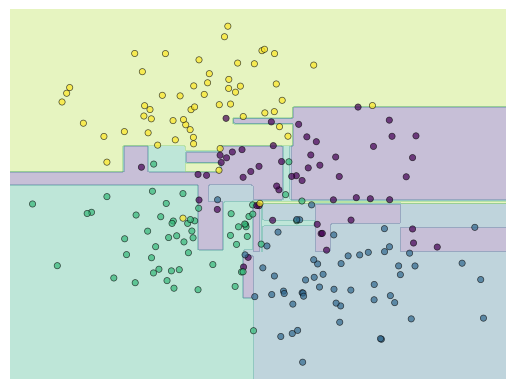

In [10]:
# re-fit model with (X_train, y_train)
tree = decision_tree.fit(X_train, y_train)

# make predictions
y_pred = tree.predict(X_train)

visualize_classifier(X_train, y_train, tree)

# compute accuarcy score
print('Accuracy score on training data: %.2f' % accuracy_score(y_train, y_pred))

Pretty accurate! Wait up a moment -- let us try the model on some test data, generated with the same distribution parameters (including the centres) but a different `random_state` (giving different point locations).

### 3.2. Fitting with the test data

Accuracy score on test data: 0.72


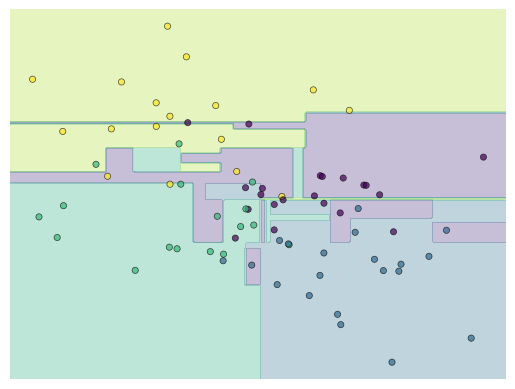

In [11]:
# plot test data
visualize_classifier(X_test, y_test, tree)

# make predictions with test data
y_test_pred = tree.predict(X_test)

# compute accuarcy score with test data
print('Accuracy score on test data: %.2f' % accuracy_score(y_test, y_test_pred))

That's not quite as good as before! The model is overfitting: it is performing well on the training set but not generalising beyond it.

Let's find out how many layers the decision tree uses:

In [12]:
print(tree.get_depth())

11


That's quite deep, can we view it?

[Text(0.6825, 0.9583333333333334, 'x[1] <= 6.148\ngini = 0.75\nsamples = 225\nvalue = [54, 55, 58, 58]'),
 Text(0.445, 0.875, 'x[0] <= -0.097\ngini = 0.682\nsamples = 163\nvalue = [45, 55, 58, 5]'),
 Text(0.2325, 0.7916666666666666, 'x[1] <= 4.608\ngini = 0.432\nsamples = 73\nvalue = [14, 2, 53, 4]'),
 Text(0.125, 0.7083333333333334, 'x[0] <= -1.449\ngini = 0.217\nsamples = 59\nvalue = [4, 2, 52, 1]'),
 Text(0.04, 0.625, 'x[0] <= -1.837\ngini = 0.053\nsamples = 37\nvalue = [0, 0, 36, 1]'),
 Text(0.02, 0.5416666666666666, 'gini = 0.0\nsamples = 27\nvalue = [0, 0, 27, 0]'),
 Text(0.06, 0.5416666666666666, 'x[0] <= -1.825\ngini = 0.18\nsamples = 10\nvalue = [0, 0, 9, 1]'),
 Text(0.04, 0.4583333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1]'),
 Text(0.08, 0.4583333333333333, 'gini = 0.0\nsamples = 9\nvalue = [0, 0, 9, 0]'),
 Text(0.21, 0.625, 'x[1] <= 3.888\ngini = 0.43\nsamples = 22\nvalue = [4, 2, 16, 0]'),
 Text(0.16, 0.5416666666666666, 'x[1] <= 2.02\ngini = 0.335\nsamples =

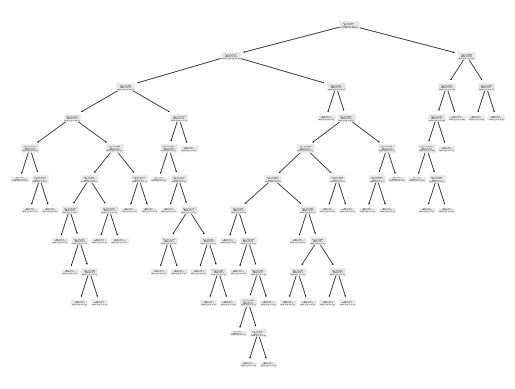

In [13]:
from sklearn.tree import plot_tree
plot_tree(tree)

## 4. Hyperparameter tuning and cross-validation

Overfitting often results when the model has too many parameters and thus fits too exactly to the training set. To alleviate overfitting, we must choose a proper number of parameters in the model. For the `DecisionTreeClassifier` class, it is controlled by the `max_depth` argument. We are going to use a training/test split and cross-validation to tune this hyperparameter. The same method can be applied to the other hyperparameters. 

Below we set up a search across `max_depth` ranging from 1 to 20 by using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method. For each value, we use a 5-fold cross-validation.

In [14]:
# set up a parameter grid to search
# here we only search max_depth
param_grid = {'max_depth': range(1, 20)}

# decision tree object
decision_tree = DecisionTreeClassifier()

# associate the grid with the object
search = GridSearchCV(decision_tree, param_grid, cv=5)

# perform search
gs = search.fit(X, y)

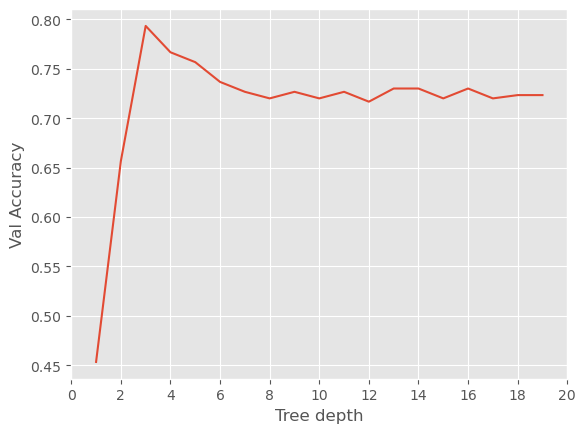

In [15]:
# plot the search result
plt.figure(dpi=100)
plt.plot(range(1, 20), search.cv_results_['mean_test_score'])
plt.xlim(0, 20)
plt.xticks(list(range(0, 21, 2)))
plt.xlabel('Tree depth')
plt.ylabel('Val Accuracy')
plt.show()

We can see that the cross-validation score reaches its maximum at `max_depth=3`. We take the best performing hyperparameter and retrain the model on the full dataset. Then we can apply this tuned model to the test data and see if the accuracy improves.

We can refit the model with the best parameters found by the grid search. We can use the dictionary `gs.best_params_` to access the values for the best parameters found during the hyper parameter search.   

In [16]:
# get the best performing hyperparameter
best_max_depth = gs.best_params_['max_depth']
print('Best max_depth: %d' % best_max_depth)

# create and fit model with the best performing hyperparameter
tree = DecisionTreeClassifier(max_depth=best_max_depth).fit(X_train, y_train)

# make predictions with test data
y_test_pred = tree.predict(X_test)

# compute accuarcy score with test data
print('Accuracy score on test data: %.2f' % accuracy_score(y_test, y_test_pred))

Best max_depth: 3
Accuracy score on test data: 0.75


[Text(0.5, 0.875, 'x[1] <= 6.148\ngini = 0.75\nsamples = 100.0%\nvalue = [0.24, 0.244, 0.258, 0.258]'),
 Text(0.25, 0.625, 'x[0] <= -0.097\ngini = 0.682\nsamples = 72.4%\nvalue = [0.276, 0.337, 0.356, 0.031]'),
 Text(0.125, 0.375, 'x[1] <= 4.608\ngini = 0.432\nsamples = 32.4%\nvalue = [0.192, 0.027, 0.726, 0.055]'),
 Text(0.0625, 0.125, 'gini = 0.217\nsamples = 26.2%\nvalue = [0.068, 0.034, 0.881, 0.017]'),
 Text(0.1875, 0.125, 'gini = 0.439\nsamples = 6.2%\nvalue = [0.714, 0.0, 0.071, 0.214]'),
 Text(0.375, 0.375, 'x[1] <= 1.97\ngini = 0.531\nsamples = 40.0%\nvalue = [0.344, 0.589, 0.056, 0.011]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 19.6%\nvalue = [0.0, 1.0, 0.0, 0.0]'),
 Text(0.4375, 0.125, 'gini = 0.495\nsamples = 20.4%\nvalue = [0.674, 0.196, 0.109, 0.022]'),
 Text(0.75, 0.625, 'x[0] <= 0.861\ngini = 0.248\nsamples = 27.6%\nvalue = [0.145, 0.0, 0.0, 0.855]'),
 Text(0.625, 0.375, 'x[1] <= 7.254\ngini = 0.073\nsamples = 23.6%\nvalue = [0.038, 0.0, 0.0, 0.962]'),
 Text(0.5625

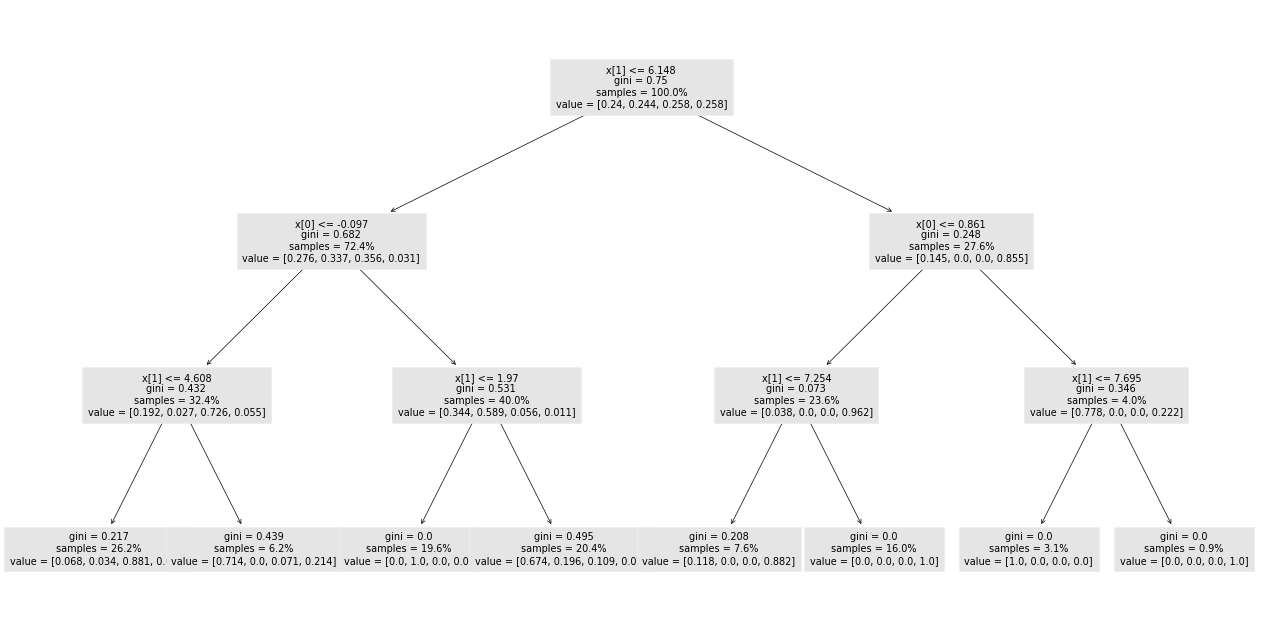

In [17]:
f, ax = plt.subplots(figsize=(16, 8))
plot_tree(tree, proportion=True, fontsize=7, ax=ax)

## 5. Advanced Concepts: Bagging and boosting

We can improve the performance of decision trees in two ways, *bagging* and *boosting*, both belonging to ensemble learning algorithms. "**Ensemble**" means that the algorithm will plant not just one tree but an ensemble of trees. 

**Bagging** (or bootstrap aggregation) reduces the variance of a decision tree by training an ensemble of trees on random subsets of the training data (with some replacement) and taking the average of the ensemble as the final result. A **Random Forest** is an example of bagging: in addition to a random subset of data, a random forest uses a random subset of features to grow each tree in the ensemble. 

**Boosting**, as another ensemble technique, grows the trees in a sequential manner, that is, the misclassified samples or errors in the prior tree will be fed into the current tree and so forth; at the end, the final result is determined by majority voting from the ensemble. **AdaBoost** and **Gradient Boosting** are the most popular boosting algorithms. From a data perspective, the data points are weighted equally in bagging and unequally in boosting, as the former is parallel and the latter sequential. 

Here we will briefly demonstrate the usage of `RandomForestClassifier`  and `AdaBoostClassifier` from `sklearn`. Gradient boosting will be used for regression in [regression_decision_tree.ipynb](regression_decision_tree.ipynb). 

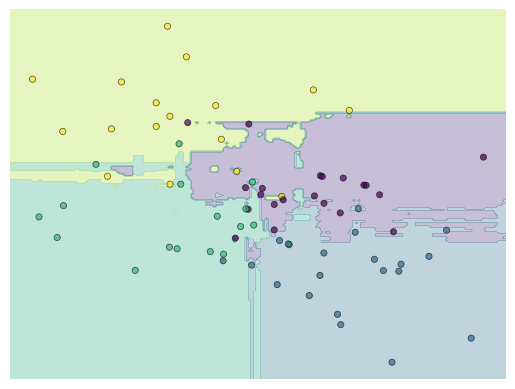

Accuracy score on test data: 1.00


In [18]:
# create and fit a random forest classifier
forest = RandomForestClassifier(n_estimators=300, random_state=0).fit(X, y)

# visulise model
plt.figure(dpi=100)
visualize_classifier(X_test, y_test, forest)
plt.show()

# make predictions with test data
y_test_pred = forest.predict(X_test)

# compute accuarcy score with test data
print('Accuracy score on test data: %.2f' % accuracy_score(y_test, y_test_pred))

/opt/jaspy/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


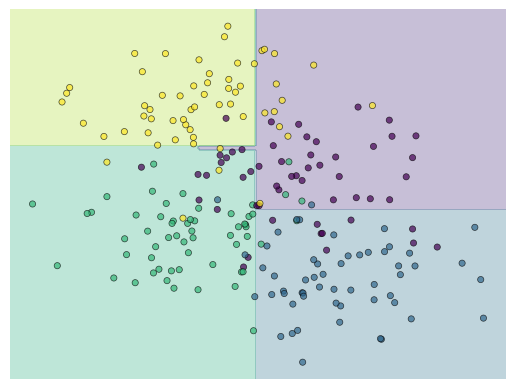

Accuracy score on test data: 0.76


In [19]:
# create and fit a AdaBoost classifier
ada = AdaBoostClassifier(n_estimators=300, learning_rate=.003, random_state=0).fit(X, y)
                        # algorithm="SAMME", algorithm="SAMME.R"

# visulise model
plt.figure(dpi=100)
visualize_classifier(X_train, y_train, ada)
plt.show()

# make predictions with test data
y_test_pred = ada.predict(X_test)

# compute accuarcy score with test data
print('Accuracy score on test data: %.2f' % accuracy_score(y_test, y_test_pred))

---

## Exercises 

There are many standard "toy" datasets for practicing classification with machine learning, such as `iris`, `wine` and `breast_cancer`. Many of them can be directly loaded from `sklearn`. Try to solve one or some of these problems using decision trees (either single or ensemble). Among these datasets, `iris` is the simplest one with the fewest features and classes.

In [20]:
# load iris dataset
iris = sklearn.datasets.load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr